# Logistic regression model for fair recidivism prediction tasks.

#### COMPAS dataset

This dataset is used to assess the likelihood that a criminal defendant will re-offend.

##### Aim 1: to make a logistic regression model using this dataset 

##### and to get the predictions, ground truth values, and protected vs non protected attributes.

#### Prediction Objective: 
Estimate the target variable 'recidivism outcome', which is either 'Did recid' or 'No recid' for each set of input features.

In [57]:
#import datasets
from aif360.datasets import StandardDataset
from aif360.datasets import CompasDataset
#import fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric

from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt



##### Note: The label value 0 in this case is considered favorable (no recidivism).

In [58]:
#import datasets
from aif360.datasets import StandardDataset
from aif360.datasets import CompasDataset
#import fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric

from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd


#load COMPAS dataset

try:
    compas = CompasDataset(
        protected_attribute_names=['sex', 'race'],
        privileged_classes=[['Female'], ['Caucasian']], 
        features_to_keep=['age', 'c_charge_degree', 'race', 'age_cat', 
                          'sex', 'priors_count', 'days_b_screening_arrest', 'c_charge_desc'],
        features_to_drop=[],
        categorical_features=['age_cat', 'c_charge_degree', 'c_charge_desc'],
        label_name='two_year_recid'
    )
    print("Dataset loaded successfully!")

    #returns the dataframe and the metadata in a tuple
    df, meta = compas.convert_to_dataframe()

except Exception as e:
    print(f"Error loading COMPAS dataset: {e}")


print("compas object type:", type(compas))
#print("Dataframe for compas dataset:", df.head())
#print("show columns and data types for dataframe: ", df.info)


Dataset loaded successfully!
compas object type: <class 'aif360.datasets.compas_dataset.CompasDataset'>


#### Label names mapping and Protected attribute mappings

In [59]:
print("label names: ", compas.metadata['label_maps'])
print("Protected attributes: ", compas.metadata['protected_attribute_maps'])

label names:  [{1.0: 'Did recid.', 0.0: 'No recid.'}]
Protected attributes:  [{0.0: 'Male', 1.0: 'Female'}, {1.0: 'Caucasian', 0.0: 'Not Caucasian'}]


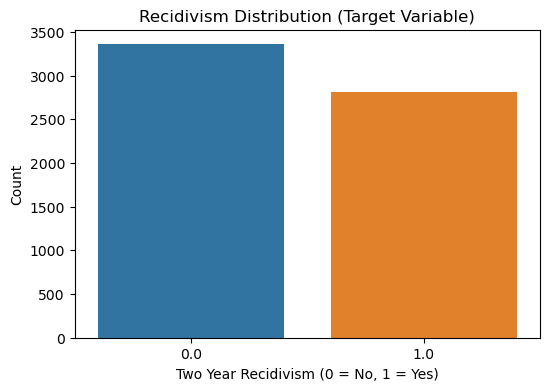

In [60]:
plt.figure(figsize=(6,4))
sns.countplot(x=df['two_year_recid'])
plt.title("Recidivism Distribution (Target Variable)")
plt.xlabel("Two Year Recidivism (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()


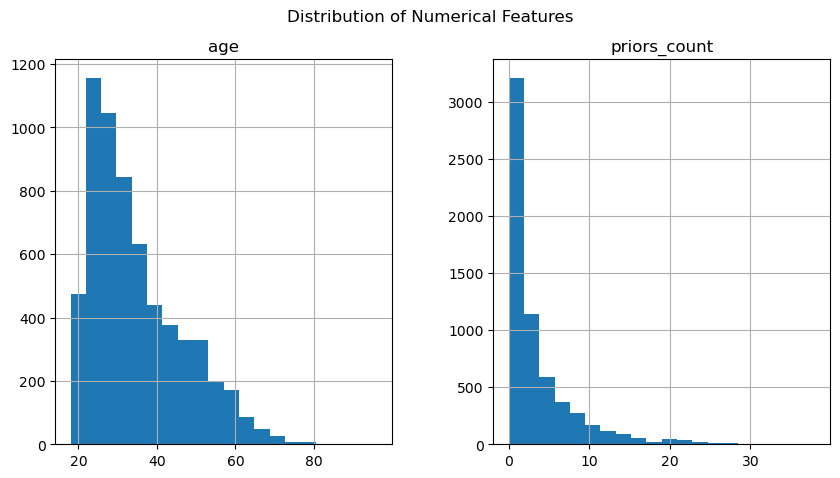

In [61]:
df[['age', 'priors_count']].hist(figsize=(10,5), bins=20)
plt.suptitle("Distribution of Numerical Features")
plt.show()

### Below is information on protected attributes 'race' and 'sex'

To show binary mappings and an idea of the distribution of data / imbalance in data

Not Caucasian - 0.0, Caucasian - 1.0: 
race
0.0    4067
1.0    2100
Name: count, dtype: int64 

Male - 0.0, Female - 1.0: 
sex
0.0    4994
1.0    1173
Name: count, dtype: int64 



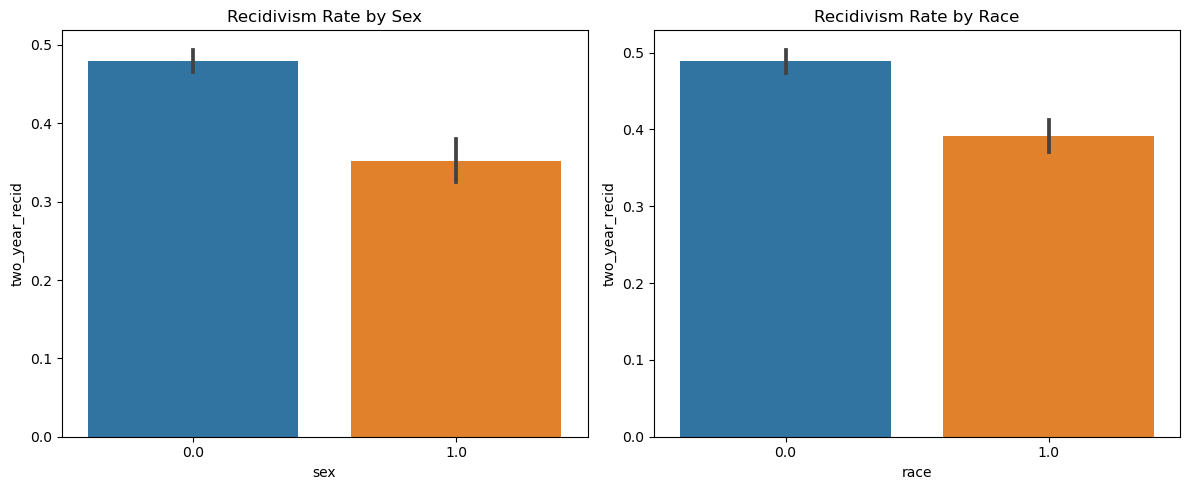

In [62]:
#to check the features that the dataset contains
#print(df.columns)

# distribution of race
print("Not Caucasian - 0.0, Caucasian - 1.0: ")
print(df['race'].value_counts(), "\n")

# distribution of sex
print("Male - 0.0, Female - 1.0: ")
print(df['sex'].value_counts(), "\n")   

plt.figure(figsize=(12,5))

# Sex vs. Recidivism
plt.subplot(1,2,1)
sns.barplot(x='sex', y='two_year_recid', data=df)
plt.title("Recidivism Rate by Sex")

# Race vs. Recidivism
plt.subplot(1,2,2)
sns.barplot(x='race', y='two_year_recid', data=df)
plt.title("Recidivism Rate by Race")

plt.tight_layout()
plt.show()




## Training a logistic regression model on the COMPAS dataset

1. Define features and target
2. Create a train/test split
3. standardise the data
4. train the LR model

### next: how to train in on protected attributes only because the above is just a normal model

In [67]:
# copy dataset to ensure original remains unchanged
df = df.copy()

#print(df.columns)

#separate features and labels
features = ['race', 'sex', 'priors_count', 'c_charge_degree=F', 'c_charge_degree=M']
target = 'two_year_recid' #binary target where 0 means does not offend, 1 means offends

X = df[features]
y = df[target]
#print(X.shape)
#print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

#print(X_train[:5])
#print("\n", y_train)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = LogisticRegression(solver='lbfgs')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

#out predictions in an array 
#array of GT labels of classification task
#array of group membership - protected vs non protected 
#indices need to align 
#[0] need to refer to the same doc and so on


def new_metric(arr_pred, arr_true, arr3): #varying these three for diff distri- protected groups can be diff sizes, edge cases 50 TP/50 TN, 10/90
    #need 2 arrays for protected and non  protected 
    #g1 - predictions and trues are lists of lists [[], []]
    #g2 - same as g1

    #this is for yiy need for GEI calculation

    #for each index calcylate benefit 
    #+= total benefit of group
    #divide by size of group - result of this is for each class 
    # same for g2
    #division result is divided by the sum of g1 and g2 - J

    #return result, indiv benefit, etc in case we need to use later

#results from this from classification 
#do a comparison from this and existing evaluation metrics in AIF360 - have a table of metric value cloumns and have indiv comp of your metric in a colum and existing metrcis 
    #each test case a diff row in table

#find method of evaluation that highlight benefits of doing this 
#can simulate classification results for edge cases - classifier foes good on one group and not on other
    #creating arrays with different distrubutions. 
    #wanting to see that my metric gives more intuitive etc results
#test cases where classifiers act differently 

#classifier level group metric that takes into consideration individual components - basic starting point



In [66]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6337115072933549
Balanced Accuracy: 0.6151949881376038
Confusion Matrix:
 [[553 119]
 [333 229]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.62      0.82      0.71       672
         1.0       0.66      0.41      0.50       562

    accuracy                           0.63      1234
   macro avg       0.64      0.62      0.61      1234
weighted avg       0.64      0.63      0.62      1234



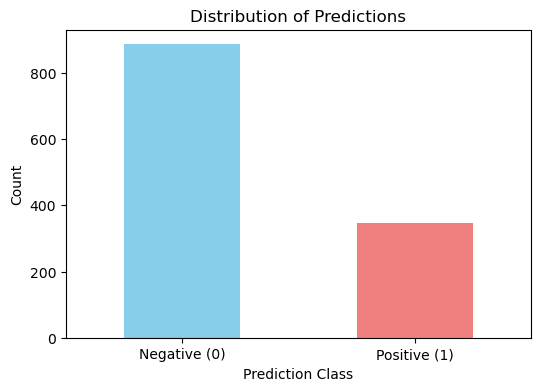

In [68]:
# Plot the distribution of positive and negative predictions
plt.figure(figsize=(6, 4))
pd.Series(y_pred).value_counts().plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title("Distribution of Predictions")
plt.xlabel("Prediction Class")
plt.ylabel("Count")
plt.xticks([0, 1], ['Negative (0)', 'Positive (1)'], rotation=0)
plt.show()

In [69]:
print(y.value_counts())

two_year_recid
0.0    3358
1.0    2809
Name: count, dtype: int64
